# Mini Projet Traitement statistique de données IESE4
Les données étudiées lors de ce projet en deux séances de TP de 4h sont issues d’une expérience en choix saccadique durant laquelle 2 images sont affichées simultanément à l’écran. Le participant doit le plus rapidement possible porter son regard sur l’image cible. Ainsi, durant une session expérimentale, le participant voit 180 paires d'images (participants PXX) ou 120 paires (participants SXX) d’images. Il doit porter dans un premier temps son regard sur l’image comportant un visage, avant de se focaliser sur les vehicules sur 60 nouveles paires d'images d'une autre session expérimentale.\
Nous réaliserons d'abord une description des données, de manière à bien les comprendre pour leur étude.

## Ehargementtude des données
Les données contiennent les resultats d'oculometrie de 29 participants différents. On peut donc s'interesser aux différences entre les participants par l'étude des donn Mais tout d'abord, les données doivent etre importés dans python pour leur traitement. Pour cela, on utilisera les librairies pandas et numpy pour les dataframe et calculs mathematiques, et matplotlib, seaborn et sklearn pour les traitements statistiques avancés et leur affichage.ées.C

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Init_df = pd.read_excel("TableTotal.xlsx",sheet_name=1,header=0,index_col=0)    # On se ramene à un DataFrame
Init_df.dropna()    # suppression des valeurs manquantes
Init_df.describe()

On sépare les données en fonction de chaque candidat dans un dataframe unique par la fonction suivante. Celle ci prends en parametre le nom du participant (ex "P01") et le dataframe de départ, et retrourne un dataframe focalisé sur un participant.

In [13]:
def split_by_participant(df, participant_col):
    return df.loc[participant_col]

Pour calculer le taux de reussite de la saccade sur un dataframe donné, on s'interesse à la variable SaccAccuracy. On programme donc la fonction suivante pour le calculer. Pour les autres données, à la difference de SaccAccuracy qui est qualitative, on calculera directement la moyenne.

In [ ]:
# Calcul du pourcentage de données de saccades correctes sur la variable "SaccAccuracy" sur un dataframe d'un participant unique
def SaccAccuracy(df):
    sum = 0
    nb = 0
    for X in df["SaccAccuracy"]:
        nb +=1
        if X == "correct":
            sum += 1
    return (sum/nb)*100

# Calcul des moyennes sur toutes les variables sur un dataframe d'un participant unique
def get_raw_data_for_participant_file(df):
    raw_data = []
    raw_data.append(SaccAccuracy(df))   # % de "correct" sur "SaccAccuracy"
    raw_data.append(df["SaccLatency"].mean())
    raw_data.append(df["SaccDuration"].mean())
    raw_data.append(df["SaccAmplitude"].mean())
    raw_data.append(df["SaccPeakofVelocity"].mean())
    return raw_data
    

Pour la description du participant 1, on aura donc :

In [ ]:
df_P01 = split_by_participant(Init_df,"P01")
print(df_P01.shape)
print(get_raw_data_for_participant_file(df_P01))

Avec df_P01.shape, on à l'information de 346 experiences valides du participant 1 sur 360, avec des données sur 10 variables.\
On peut alors généraliser l'etude d'un seul participant à tout les participants avec les fonctions suivantes, pour obtenir un dataframe comprenant les % de "correct" et moyennes sur chaque variable pour chaque participant :

In [ ]:
# Recuperation des moyennes des variables sur tout les participants
def get_list_data_for_participant(list_df):
    raw_data = []
    for df_i in list_df:
        raw_data.append(get_raw_data_for_participant_file(df_i))
    return raw_data

# Creation et mise en forme en dataframe des données de get_list_data_for_participant
def get_per_participant_dataframe(Init_df, column_names):   
    row_indices = Init_df.index.unique()    #recuperation des noms des lignes (participants)
    list_df = []
    for names in row_indices:
        list_df.append(split_by_participant(Init_df,names))
    data = get_list_data_for_participant(list_df)
    df = pd.DataFrame(data, columns=column_names,index=row_indices)
    return df    

In [ ]:
column_names = ["SaccAccuracy", "SaccLatency", "SaccDuration", "SaccAmplitudeX", "SaccPeakofVelocity"]  # Definition des noms des colonnes du dataframe
Xdf = get_per_participant_dataframe(Init_df,column_names)
print(Xdf)

### Analyse univariée
Avec l'analyse précédente, on recupere un dataframe Xdf pandas exploitable pour caracteriser les différences entre les participants à l'experience. On propose alors de réaliser une analyse univariée des données par les box plot :

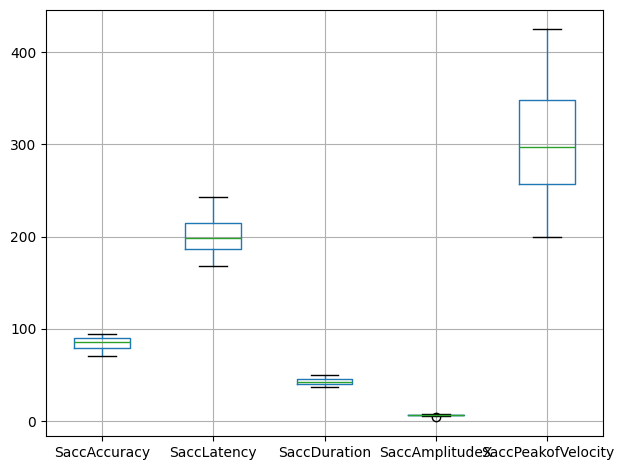

In [129]:
plt.figure()
Xdf.boxplot()
plt.tight_layout()
plt.show()

# Analyse bivariée

In [151]:
Xdf.mean()

SaccAccuracy           84.383426
SaccLatency           199.273863
SaccDuration           43.223663
SaccAmplitudeX          6.689452
SaccPeakofVelocity    302.972621
dtype: float64

<Figure size 640x480 with 0 Axes>

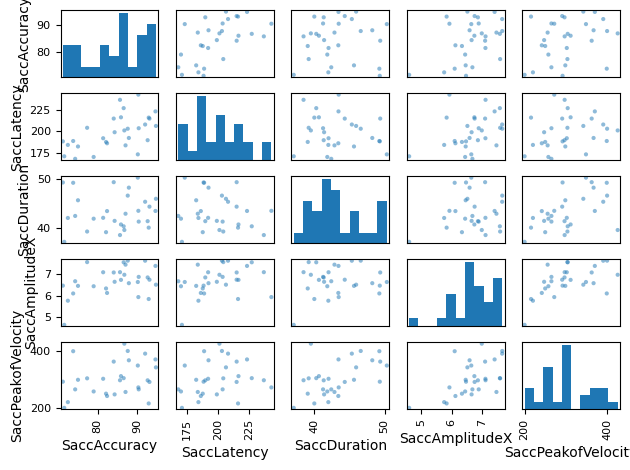

In [152]:
plt.figure()
pd.plotting.scatter_matrix(Xdf.iloc[:])
plt.tight_layout()
plt.show()

# ACP Centré et réduite
ACP sur le Dataframe avec les données des moyennes pour chaque participant. L'ACP sans être centré et réduite n'as pas de sens car la variable Peak of Velocity possède une variance et une moyenne très grande par rapport aux autres.

In [153]:
Xcr = (Xdf - Xdf.mean())/ Xdf.std() # centrage et réduction
Xcr.describe()

acp = PCA()
Xacp = acp.fit_transform(Xcr)
print(Xacp.shape)
[n,p]=Xacp.shape

(29, 5)


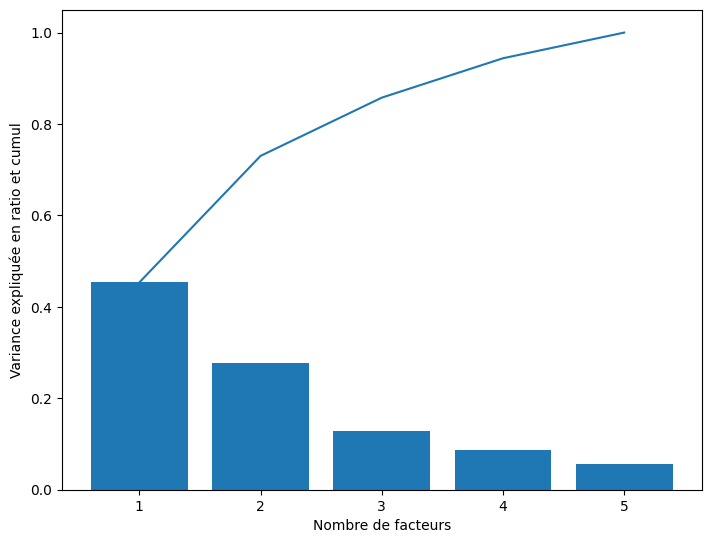

In [154]:
plt.figure()
# Graphique des variances expliquées
plt.bar(np.arange(1, p+1), acp.explained_variance_ratio_)
plt.plot(np.arange(1, p+1), np.cumsum(acp.explained_variance_ratio_))
plt.ylabel("Variance expliquée en ratio et cumul")
plt.xlabel("Nombre de facteurs")
plt.subplots_adjust(left=0,
					bottom=0, 
					right=1, 
					top=1, 
					wspace=0.4, 
					hspace=0.4)
plt.show()

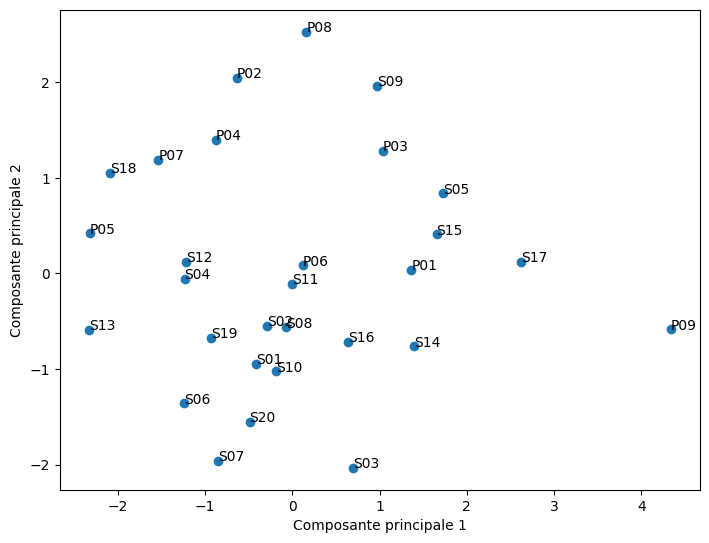

In [155]:
coord=acp.fit_transform(Xacp)
plt.scatter(coord[:,0],coord[:,1])
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
for j in range(n):
    plt.annotate(Xcr.index[j], (coord[j, 0], coord[j, 1]))   # affichage des etiquettes sur les points des indivudus
plt.subplots_adjust(left=0,
					bottom=0, 
					right=1, 
					top=1, 
					wspace=0.4, 
					hspace=0.4)
plt.show()

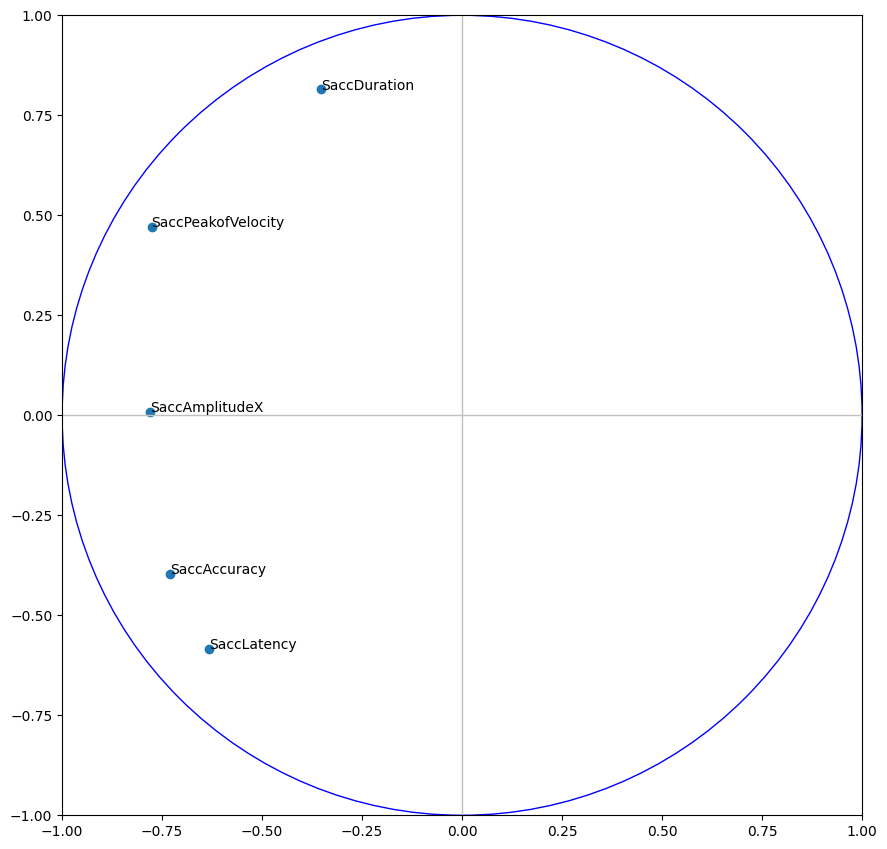

In [156]:
# On va ici calculer la corrélation entre les facteurs et les variables de départ
XArray = pd.DataFrame.to_numpy(Xcr)

corvar = np.zeros((p, 2))
for k in range(2):
    for j in range(p):
        corvar[j, k] = np.corrcoef(coord[:, k], XArray[:, j])[0, 1]

# Cercle des corrélations
fig, axes = plt.subplots(figsize=(8, 8))
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
plt.scatter(corvar[:, 0], corvar[:, 1])

# affichage des étiquettes (noms des variables)
for j in range(p):
    plt.annotate(Xcr.columns[j], (corvar[j, 0], corvar[j, 1]))

# On ajoute les axes
plt.plot([-1, 1], [0, 0], color='silver', linestyle='-', linewidth=1)
plt.plot([0, 0], [-1, 1], color='silver', linestyle='-', linewidth=1)
# On ajoute un cercle
cercle = plt.Circle((0, 0), 1, color='blue', fill=False)
axes.add_artist(cercle)
plt.subplots_adjust(left=0,
					bottom=0, 
					right=1, 
					top=1, 
					wspace=0.4, 
					hspace=0.4)
plt.show()

In [157]:
print(pd.DataFrame(
    {'id': Used_dataframe.columns, 'COR_1': corvar[:, 0], 'COR_2': corvar[:, 1]}))


                   id     COR_1     COR_2
0        SaccAccuracy -0.729522 -0.397100
1         SaccLatency -0.633066 -0.584253
2        SaccDuration -0.353544  0.814634
3      SaccAmplitudeX -0.779042  0.008514
4  SaccPeakofVelocity -0.776379  0.470030


# Différence entre error et correct

In [162]:
Error_df_tot = Init_df[Init_df['SaccAccuracy'] != 'correct']
Error_df_tot.describe()

,TrialID,SaccLatency,SaccDuration,SaccAmplitudeX,SaccAmplitude,SaccOrientation,SaccPeakofVelocity
count,7224.000000,7224.000000,7224.000000,7224.000000,7224.000000,7224.000000,7224.000000
mean,66.336240,198.126384,43.474391,6.657120,6.692676,9.451137,305.415213
std,42.119238,38.712692,9.745120,1.740078,1.739711,126.531301,79.356683
min,1.000000,51.000000,12.000000,0.160986,1.000005,-180.000000,70.500000
25%,32.000000,173.000000,38.000000,5.699547,5.728255,-10.620558,251.100006
50%,63.000000,195.000000,43.000000,6.718420,6.746077,0.728809,301.799988
75%,95.000000,220.000000,49.000000,7.750888,7.786746,170.593357,358.700012
max,178.000000,360.000000,99.000000,12.925971,12.997998,179.973206,686.700012


In [163]:
Correct_df_tot = Init_df[Init_df['SaccAccuracy'] != 'error']
Correct_df_tot.describe()

,TrialID,SaccLatency,SaccDuration,SaccAmplitudeX,SaccAmplitude,SaccOrientation,SaccPeakofVelocity
count,7224.000000,7224.000000,7224.000000,7224.000000,7224.000000,7224.000000,7224.000000
mean,66.336240,198.126384,43.474391,6.657120,6.692676,9.451137,305.415213
std,42.119238,38.712692,9.745120,1.740078,1.739711,126.531301,79.356683
min,1.000000,51.000000,12.000000,0.160986,1.000005,-180.000000,70.500000
25%,32.000000,173.000000,38.000000,5.699547,5.728255,-10.620558,251.100006
50%,63.000000,195.000000,43.000000,6.718420,6.746077,0.728809,301.799988
75%,95.000000,220.000000,49.000000,7.750888,7.786746,170.593357,358.700012
max,178.000000,360.000000,99.000000,12.925971,12.997998,179.973206,686.700012
